<div class="alert alert-block alert-success" !important>
    <h1 class="alert-heading">Assignment 08</h1>
In the previous assignment, we featurized the `retail-churn.csv` data using RFM. In this assignment, we build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end.</div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


<div class="alert alert-block alert-success"><h4 class="alert-heading">1. Rerun the feature engineering steps on the data to extract RFM features. <span style="color:red" float:right>[2 point]</span></h4></div>

In [2]:
# Create our dollar & quantity aggregrate columns
churn['timestamp'] = churn['timestamp'].astype('datetime64')
churn['date'] = churn['timestamp'].dt.date.astype('datetime64')
churn_agg = churn.groupby(['user_id', 'date']).agg({'quantity': sum, 'dollar':sum}).sort_values(by=['user_id', 'date'])

In [3]:
# Create our quantity and dollar 7 day rolling sum columns
churn_roll = churn_agg.reset_index().set_index('date').copy()
churn_roll = churn_roll.groupby('user_id')[['dollar', 'quantity']].rolling('7D').sum()
churn_roll.rename(columns={
    'quantity': 'quantity_roll_sum_7D',
    'dollar': 'dollar_roll_sum_7D'
}, inplace=True)
churn_roll['quantity_roll_sum_7D'] = churn_roll['quantity_roll_sum_7D'].astype('int')
churn_roll['dollar_roll_sum_7D'] = churn_roll['dollar_roll_sum_7D'].astype('int')

In [4]:
# Create our last_visit_ndays column
churn_roll.reset_index(inplace=True)
churn_roll['last_visit_ndays'] = churn_roll.groupby('user_id')['date'].diff()

In [5]:
# Fille NaT values with timedelta, reorder columns, and merge with aggregate data.
churn_roll.set_index(['user_id', 'date'], inplace=True)
churn_roll.fillna(value=pd.Timedelta('120 days'), inplace=True)
churn_roll = churn_roll.merge(churn_agg, left_index=True, right_index=True)

<div class="alert alert-block alert-success"><h4 class="alert-heading">2. Train a k-means algorithm on the RFM features using $k = 5$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the standardized scale. <span style="color:red" float:right>[2 point]</span> </h4></div>

<span style="color:maroon" float:right><em>The original question stated to use k = 5, I suspect this was a typo as the next question mentinoed that our original choice of k = 5 was arbitray.  As such the following is calculated with 5 clusters.  Simple enough to change to though</em></span>

In [6]:
# Convert the timedelta from a datetime object into an integer value representing number of days.
#   Need to have it as an integer to perform math operations on it.
churn_roll['last_visit_int'] = churn_roll['last_visit_ndays'].astype('int') / (1 * 10 ** 9) / 60 / 60 / 24

In [7]:
# Original column names and combinations of each column name
columns_orig = ['last_visit_int', 'dollar_roll_sum_7D', 'quantity_roll_sum_7D']
pairs_orig = list(combinations(columns_orig, 2))
# Column names for normalized data and combinations of normalized columns names
columns_norm = [col + "_norm" for col in columns_orig]
pairs_norm = list(combinations(columns_norm, 2))

In [8]:
# Standardize our data so no one feature dominates our k-means algorithm.
churn_roll[columns_norm] = (churn_roll[columns_orig].values - churn_roll[columns_orig].values.mean(axis=0))  / churn_roll[columns_orig].values.std(axis=0)
churn_roll[columns_norm].describe()

,last_visit_int_norm,dollar_roll_sum_7D_norm,quantity_roll_sum_7D_norm
count,3.705800e+04,3.705800e+04,3.705800e+04
mean,7.362740e-17,2.377551e-17,1.380514e-17
std,1.000013e+00,1.000013e+00,1.000013e+00
min,-8.818241e-01,-5.918738e-01,-5.530710e-01
25%,-7.997960e-01,-4.324457e-01,-4.157013e-01
50%,-5.537119e-01,-2.412283e-01,-1.867517e-01
75%,1.558510e+00,1.219403e-01,1.337778e-01
max,1.558510e+00,3.943133e+01,7.536662e+01


In [9]:
# Define the number of clusters for our KMeans, fit, and predic
n_clusters = 5
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # Initialize
kmeans.fit(churn_roll[columns_norm])
churn_roll['cluster'] = kmeans.predict(churn_roll[columns_norm])
churn_roll.head(10)

dollar_roll_sum_7D  quantity_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
1113    2000-11-12                 420                     5         120 days   
        2000-11-26                 558                     3          14 days   
        2000-11-27                1182                     9           1 days   
        2001-01-06                 628                     9          40 days   
1250    2001-02-04                 734                     5         120 days   
        2001-02-10                1583                    18           6 days   
1823    2000-11-02                1256                    16         120 days   
        2000-11-06                2174                    22           4 days   
        2001-01-24                 433                     3          79 days   
4947    2000-12-03                1875                    24         120 days   

                    quantity  dollar  last_visit_int  last_visit_int_norm  \
user_id date                                                                
1113    2000-11-12         5     420           120.0             1.558510   
        2000-11-26         3     558            14.0            -0.615233   
        2000-11-27         6     624             1.0            -0.881824   
        2001-01-06         9     628            40.0            -0.082051   
1250    2001-02-04         5     734           120.0             1.558510   
        2001-02-10        13     849             6.0            -0.779289   
1823    2000-11-02        16    1256           120.0             1.558510   
        2000-11-06         6     918             4.0            -0.820303   
        2001-01-24         3     433            79.0             0.717723   
4947    2000-12-03        24    1875           120.0             1.558510   

                    dollar_roll_sum_7D_norm  quantity_roll_sum_7D_norm  \
user_id date                                                             
1113    2000-11-12                -0.391987                  -0.369911   
        2000-11-26                -0.325518                  -0.461491   
        2000-11-27                -0.024965                  -0.186752   
        2001-01-06                -0.291802                  -0.186752   
1250    2001-02-04                -0.240747                  -0.369911   
        2001-02-10                 0.168179                   0.225358   
1823    2000-11-02                 0.010678                   0.133778   
        2000-11-06                 0.452838                   0.408517   
        2001-01-24                -0.385725                  -0.461491   
4947    2000-12-03                 0.308823                   0.500097   

                    cluster  
user_id date                 
1113    2000-11-12        2  
        2000-11-26        0  
        2000-11-27        0  
        2001-01-06        0  
1250    2001-02-04        2  
        2001-02-10        0  
1823    2000-11-02        2  
        2000-11-06        0  
        2001-01-24        2  
4947    2000-12-03        2

In [10]:
kmeans.inertia_

25307.75269272067

In [11]:
# Create a dataframe of our clusters that can be used for plotting.
clusters_norm = pd.DataFrame(kmeans.cluster_centers_, columns=columns_norm)

In [12]:
# Plotting function for our main data, their clusters, and the column pairs.
def Plot2DKMeans(df, cf, pairs, title):
    fig, axs = plt.subplots(nrows = len(pairs), ncols = 1, figsize = (18, len(pairs) * 5))
    fig.suptitle(title, fontsize=24)
    plt.subplots_adjust(top=0.85)
    for j, pair in enumerate(pairs):
        for i in range(cf.shape[0]):
            color = sns.color_palette("deep", 12)[i]
            marker = ['s', 'o', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'][i]
            sns.scatterplot(x = pair[0], y = pair[1], color=color, marker=marker, data = df.loc[df['cluster'] == i], ax = axs[j], legend = False)
            sns.scatterplot(x = cf[pair[0]], y=cf[pair[1]], color='black', marker = 'X', ax = axs[j], s=200)
    plt.show()

<span style="color:maroon" float:right><em>The following scatter plots are based on the standardized data with the cluster centers represented as X's.</em></span>

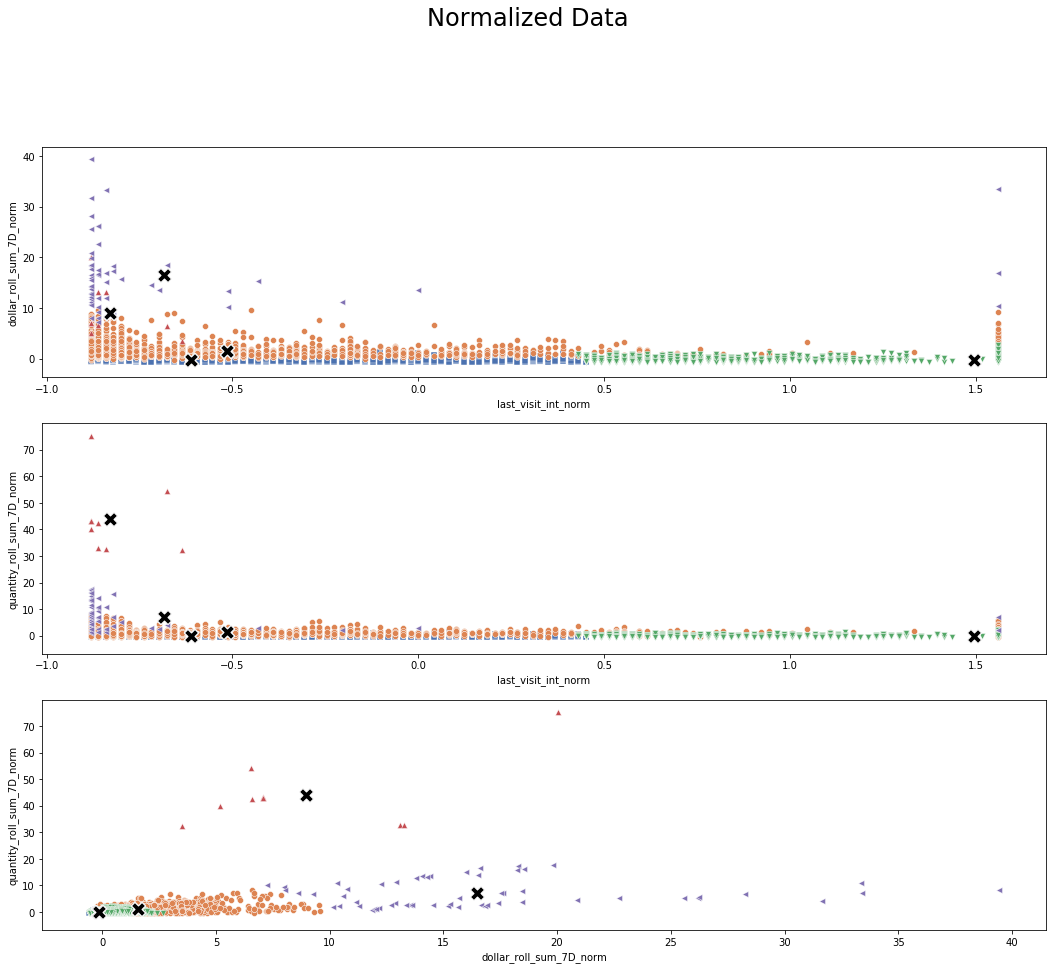

In [13]:
Plot2DKMeans(churn_roll, clusters_norm, pairs_norm, "Normalized Data")

<span style="color:maroon" float:right><em>The following scatter plots are based on the original data with the cluster centers are scaled up and  represented at the original scale.  Plotthis this data shows the same thing as our normalized ones above, cluster centers are still in the same relative positions for their data.</em></span>

In [14]:
# We need to scale our clusters up back to the original data.
#   Essentially the opposite of our standardization, take our normalized clusters, multiple by standard deviation and add the mean
clusters_orig = clusters_norm * churn_roll[columns_orig].values.std(axis=0) + churn_roll[columns_orig].values.mean(axis=0)
clusters_orig.columns = clusters_orig.columns.str.replace("_norm", "")

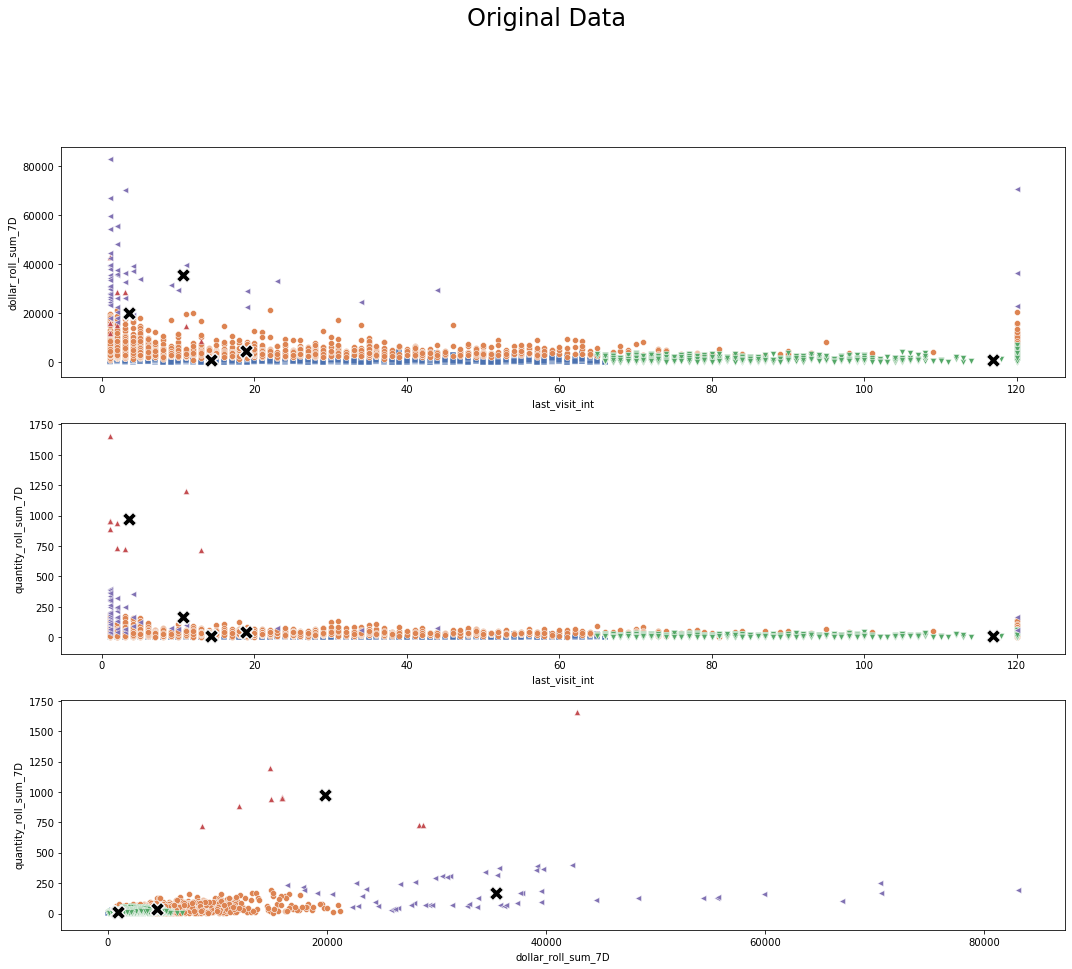

In [15]:
Plot2DKMeans(churn_roll, clusters_orig, pairs_orig, "Original Data")

<div class="alert alert-block alert-success"><h4 class="alert-heading">3. Our earlier choice of $k=5$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 3 to 15. <span style="color:red" float:right>[3 point]</span></hr></div>

In [16]:
# Calculates scree for each cluster size in the range passed in for the given dataframe.  Returns a list of clusters and their inertia.
def calculate_scree(sample_range, df):
    scree = []
    for k in range (sample_range[0], sample_range[1]):
        n_clusters = k
        kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
        kmeans.fit(df)
        scree.append((k, kmeans.inertia_))
    return scree

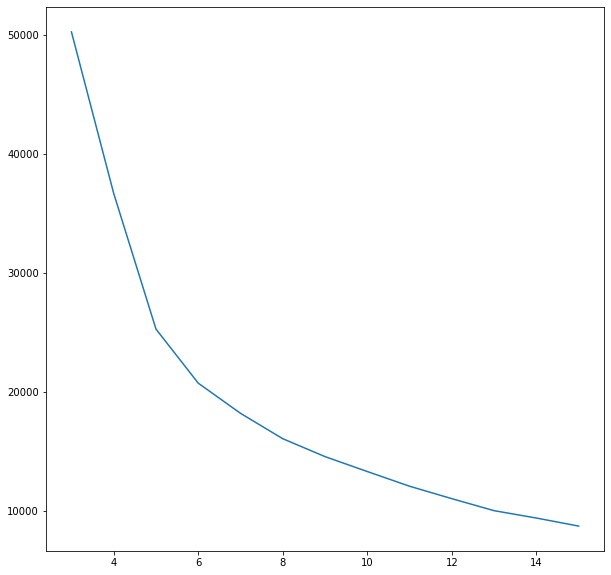

In [17]:
# Calculate and display scree plot for the stated range of 3 to 15
sample_range = (3, 16)
scree_array = np.array(calculate_scree(sample_range, churn_roll[columns_norm]))
fig, ax = plt.subplots(figsize=(10,10))
ax.ticklabel_format(style='plain')
ax.plot(range(sample_range[0], sample_range[1]), [x[1] for x in scree_array])
plt.show()

<div class="alert alert-block alert-success"><h4 class="alert-heading">4. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span></h4></div>

<span style="color:maroon" float:right><em>Unlike our classroom example data, there is no distinct point at which the scree plot really levels out.  10 seems like a viable number of clusters, after 10 there are diminishing returns on the amount of inertia lost per cluster without giving us too many clusters to work with.</em></span>

<div class="alert alert-block alert-success"><h4 class="alert-heading">5. Train a k-means algorithm on the RFM features using your new value of $k$. Report the  size, mean and standard deviation for the RFM features for each cluster. <span style="color:red" float:right>[2 point]</span></h4></div>

In [18]:
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit(churn_roll[columns_norm])
churn_roll['cluster'] = kmeans.predict(churn_roll[columns_norm])
churn_roll.head(10)

dollar_roll_sum_7D  quantity_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
1113    2000-11-12                 420                     5         120 days   
        2000-11-26                 558                     3          14 days   
        2000-11-27                1182                     9           1 days   
        2001-01-06                 628                     9          40 days   
1250    2001-02-04                 734                     5         120 days   
        2001-02-10                1583                    18           6 days   
1823    2000-11-02                1256                    16         120 days   
        2000-11-06                2174                    22           4 days   
        2001-01-24                 433                     3          79 days   
4947    2000-12-03                1875                    24         120 days   

                    quantity  dollar  last_visit_int  last_visit_int_norm  \
user_id date                                                                
1113    2000-11-12         5     420           120.0             1.558510   
        2000-11-26         3     558            14.0            -0.615233   
        2000-11-27         6     624             1.0            -0.881824   
        2001-01-06         9     628            40.0            -0.082051   
1250    2001-02-04         5     734           120.0             1.558510   
        2001-02-10        13     849             6.0            -0.779289   
1823    2000-11-02        16    1256           120.0             1.558510   
        2000-11-06         6     918             4.0            -0.820303   
        2001-01-24         3     433            79.0             0.717723   
4947    2000-12-03        24    1875           120.0             1.558510   

                    dollar_roll_sum_7D_norm  quantity_roll_sum_7D_norm  \
user_id date                                                             
1113    2000-11-12                -0.391987                  -0.369911   
        2000-11-26                -0.325518                  -0.461491   
        2000-11-27                -0.024965                  -0.186752   
        2001-01-06                -0.291802                  -0.186752   
1250    2001-02-04                -0.240747                  -0.369911   
        2001-02-10                 0.168179                   0.225358   
1823    2000-11-02                 0.010678                   0.133778   
        2000-11-06                 0.452838                   0.408517   
        2001-01-24                -0.385725                  -0.461491   
4947    2000-12-03                 0.308823                   0.500097   

                    cluster  
user_id date                 
1113    2000-11-12        2  
        2000-11-26        0  
        2000-11-27        0  
        2001-01-06        9  
1250    2001-02-04        2  
        2001-02-10        6  
1823    2000-11-02        2  
        2000-11-06        6  
        2001-01-24        9  
4947    2000-12-03        1

In [19]:
clusters_norm = pd.DataFrame(kmeans.cluster_centers_, columns=columns_norm)

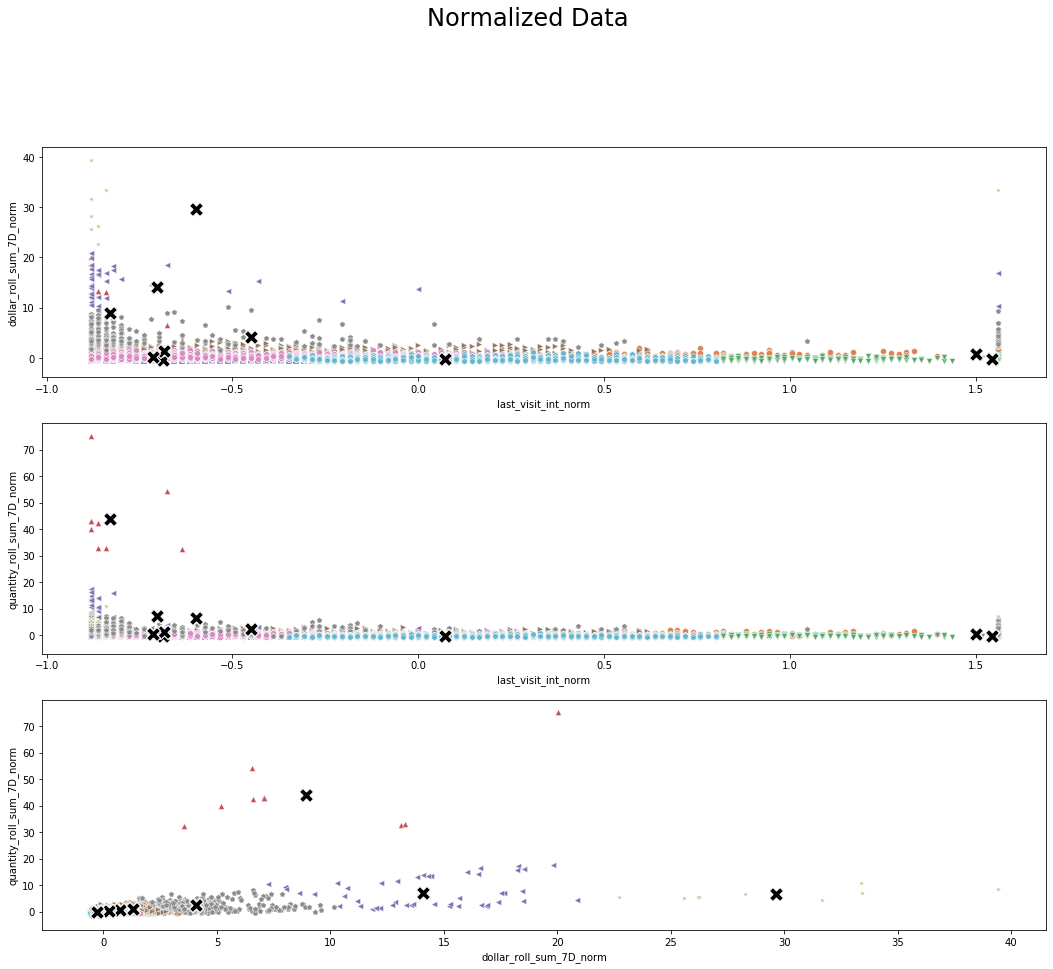

In [20]:
Plot2DKMeans(churn_roll, clusters_norm, pairs_norm, "Normalized Data")

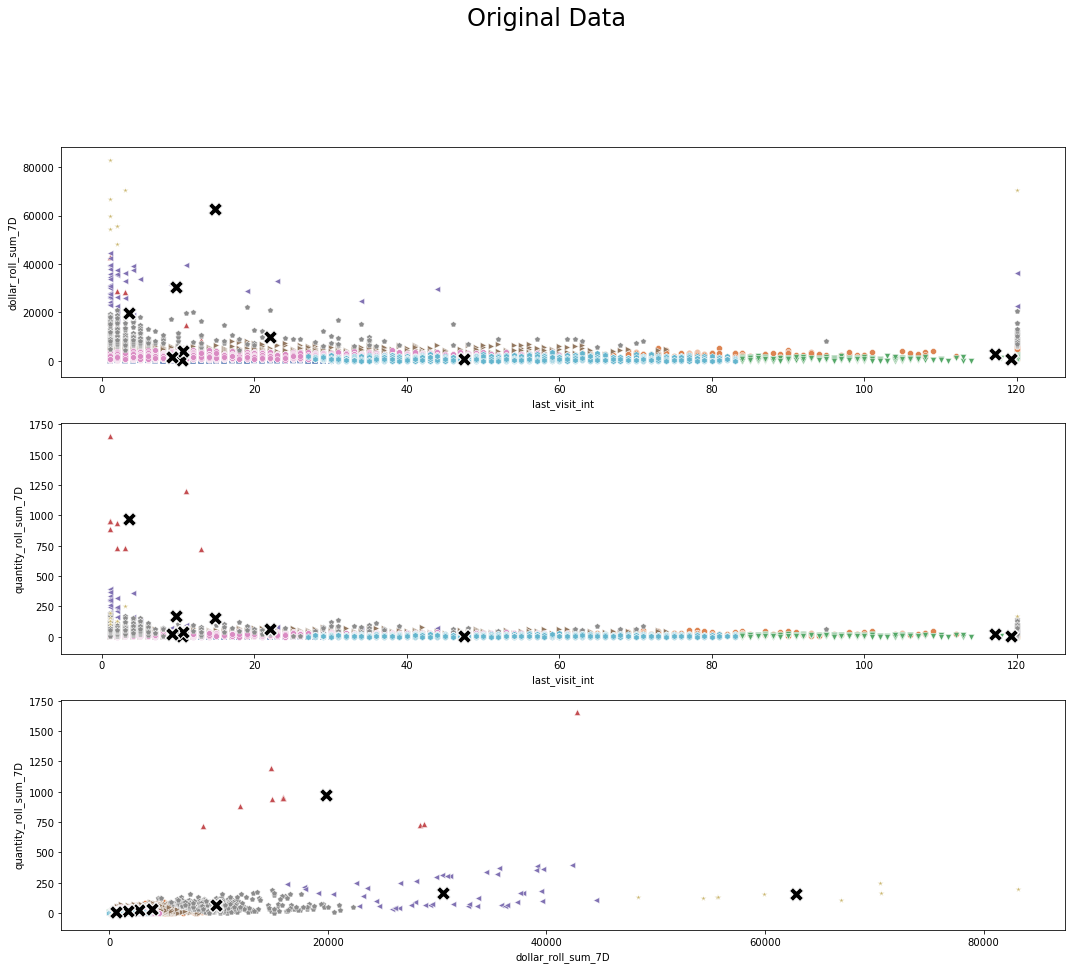

In [21]:
clusters_orig = clusters_norm * churn_roll[columns_orig].values.std(axis=0) + churn_roll[columns_orig].values.mean(axis=0)
clusters_orig.columns = clusters_orig.columns.str.replace("_norm", "")
Plot2DKMeans(churn_roll, clusters_orig, pairs_orig, "Original Data")

<span style="color:maroon" float:right><em>The following matrix provides the requested size, mean, and standard deviation for each cluster.</em></span>

In [22]:
churn_roll.groupby('cluster')[columns_orig].describe().T

cluster                                0            1            2  \
last_visit_int       count  13913.000000  2014.000000  8313.000000   
                     mean      10.489973   117.180735   119.268495   
                     std        7.462302    10.627370     4.534844   
                     min        1.000000    61.000000    84.000000   
                     25%        4.000000   120.000000   120.000000   
                     50%        9.000000   120.000000   120.000000   
                     75%       15.000000   120.000000   120.000000   
                     max       30.000000   120.000000   120.000000   
dollar_roll_sum_7D   count  13913.000000  2014.000000  8313.000000   
                     mean     501.357004  2728.881827   608.038614   
                     std      336.601825  1203.746557   464.517115   
                     min        5.000000   850.000000     9.000000   
                     25%      237.000000  1879.000000   236.000000   
                     50%      443.000000  2446.000000   500.000000   
                     75%      710.000000  3232.750000   899.000000   
                     max     2090.000000  8869.000000  2612.000000   
quantity_roll_sum_7D count  13913.000000  2014.000000  8313.000000   
                     mean       6.623661    26.054618     7.276916   
                     std        3.841429    11.896139     4.942652   
                     min        1.000000     1.000000     1.000000   
                     25%        3.000000    19.000000     3.000000   
                     50%        6.000000    24.000000     6.000000   
                     75%        9.000000    32.000000    10.000000   
                     max       20.000000    92.000000    27.000000   

cluster                                3             4            5  \
last_visit_int       count     10.000000     47.000000  2095.000000   
                     mean       3.600000      9.680851    10.671599   
                     std        4.501851     25.036587    14.683611   
                     min        1.000000      1.000000     1.000000   
                     25%        1.000000      1.000000     2.000000   
                     50%        1.500000      2.000000     4.000000   
                     75%        2.750000      4.000000    14.000000   
                     max       13.000000    120.000000    74.000000   
dollar_roll_sum_7D   count     10.000000     47.000000  2095.000000   
                     mean   19804.400000  30502.361702  3948.911695   
                     std    10368.944479   6982.416109  1241.843941   
                     min     8558.000000  16315.000000   720.000000   
                     25%    14842.500000  25952.000000  3014.000000   
                     50%    15909.500000  30468.000000  3710.000000   
                     75%    25309.750000  36004.000000  4668.500000   
                     max    42838.000000  44581.000000  8290.000000   
quantity_roll_sum_7D count     10.000000     47.000000  2095.000000   
                     mean     972.800000    170.234043    37.800955   
                     std      281.553547    114.481670    13.743419   
                     min      721.000000     33.000000     3.000000   
                     25%      770.500000     69.000000    29.000000   
                     50%      947.000000    141.000000    37.000000   
                     75%      954.500000    255.500000    45.500000   
                     max     1659.000000    397.000000    94.000000   

cluster                               6             7             8  \
last_visit_int       count  6853.000000    369.000000      9.000000   
                     mean      9.154969     22.121951     14.777778   
                     std      10.506811     38.882400     39.464471   
                     min       1.000000      1.000000      1.000000   
                     25%       2.000000      1.000000      1.000000   
                     50%       5.000000      4.

<div class="alert alert-block alert-success"><h4 class="alert-heading">6. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span></hr></div>

<span style="color:maroon" float:right><em>Selecting clusters 3, 4, and 8</em></span>

<span style="color:maroon" float:right><em>Grouped by each clustern and transposing the matrix to be more readable, we are able to see the count, mean, std, min, max, and quartiles for each of our clusters.  This largely goes with the transposed table just above.</em></span>

In [23]:
churn_roll.groupby('cluster').describe().T

cluster                                                   0  \
dollar_roll_sum_7D        count                       13913   
                          mean                      501.357   
                          std                       336.602   
                          min                             5   
                          25%                           237   
                          50%                           443   
                          75%                           710   
                          max                          2090   
quantity_roll_sum_7D      count                       13913   
                          mean                      6.62366   
                          std                       3.84143   
                          min                             1   
                          25%                             3   
                          50%                             6   
                          75%                             9   
                          max                            20   
last_visit_ndays          count                       13913   
                          mean   10 days 11:45:33.702292819   
                          std     7 days 11:05:42.850788902   
                          min               1 days 00:00:00   
                          25%               4 days 00:00:00   
                          50%               9 days 00:00:00   
                          75%              15 days 00:00:00   
                          max              30 days 00:00:00   
quantity                  count                       13913   
                          mean                      4.89902   
                          std                       3.38657   
                          min                             1   
                          25%                             2   
                          50%                             4   
                          75%                             7   
                          max                            19   
dollar                    count                       13913   
                          mean                      381.611   
                          std                       312.237   
                          min                             5   
                          25%                           147   
                          50%                           296   
                          75%                           534   
                          max                          2090   
last_visit_int            count                       13913   
                          mean                        10.49   
                          std                        7.4623   
                          min                             1   
                          25%                             4   
                          50%                             9   
                          75%                            15   
                          max                            30   
last_visit_int_norm       count                       13913   
                          mean                    -0.687213   
                          std                      0.153029   
                          min                     -0.881824   
                          25%                     -0.820303   
                          50%                     -0.717768   
                          75%                     -0.594726   
                          max                     -0.287121   
dollar_roll_sum_7D_norm   count                       13913   
                          mean                    -0.352801   
                          std                      0.162126   
                          min                     -0.591874   
                          25%                      -0.48013   
                          50%                     -0.380909   
                          75%  

<span style="color:maroon" float:right><em>Immediately what I find interesting is the is the disproportionate counts of each cluster.  We have three clusters that each contain under 50 total entries.  These three clusters (3, 4, and 8) also comprise the highest dollaring rolling sum values.  Cluster 0 had the largest number of transactions and also corresponds to the least dollar rolling sum values.  Of of these three clusters (3 & 4) also have the most recent transactions, however not cluster 8</em></span>

<div class="alert alert-block alert-success" !important><h1 class="alert-heading">End of assignment</h1></div>

<span style="color:maroon" float:right><em>Following I add in a fourth feature, frequency.</em></span>

In [24]:
frequency = churn_agg.groupby('user_id')['quantity'].count().to_frame()
frequency = frequency.rename(columns={'quantity': 'frequency'})
churn_roll = churn_roll.merge(frequency, how="left", left_index=True, right_index=True)

In [25]:
# Original column names
columns_orig = ['last_visit_int', 'frequency', 'dollar_roll_sum_7D', 'quantity_roll_sum_7D', ]
pairs_orig = list(combinations(columns_orig, 2))

# And column names for the standardized data
columns_norm = [col + "_norm" for col in columns_orig]
pairs_norm = list(combinations(columns_norm, 2))


In [26]:
churn_roll[columns_norm] = (churn_roll[columns_orig].values - churn_roll[columns_orig].values.mean(axis=0))  / churn_roll[columns_orig].values.std(axis=0)
churn_roll[columns_norm].describe()

,last_visit_int_norm,frequency_norm,dollar_roll_sum_7D_norm,quantity_roll_sum_7D_norm
count,3.705800e+04,3.705800e+04,3.705800e+04,3.705800e+04
mean,7.362740e-17,3.681370e-17,2.377551e-17,1.380514e-17
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-8.818241e-01,-8.072320e-01,-5.918738e-01,-5.530710e-01
25%,-7.997960e-01,-6.274028e-01,-4.324457e-01,-4.157013e-01
50%,-5.537119e-01,-3.576591e-01,-2.412283e-01,-1.867517e-01
75%,1.558510e+00,1.818285e-01,1.219403e-01,1.337778e-01
max,1.558510e+00,4.857387e+00,3.943133e+01,7.536662e+01


In [27]:
n_clusters = 10
kmeans = KMeans(n_clusters = n_clusters, random_state = 0) # Initialize
kmeans.fit(churn_roll[columns_norm])
churn_roll['cluster'] = kmeans.predict(churn_roll[columns_norm])
churn_roll.head(10)

dollar_roll_sum_7D  quantity_roll_sum_7D last_visit_ndays  \
user_id date                                                                    
1113    2000-11-12                 420                     5         120 days   
        2000-11-26                 558                     3          14 days   
        2000-11-27                1182                     9           1 days   
        2001-01-06                 628                     9          40 days   
1250    2001-02-04                 734                     5         120 days   
        2001-02-10                1583                    18           6 days   
1823    2000-11-02                1256                    16         120 days   
        2000-11-06                2174                    22           4 days   
        2001-01-24                 433                     3          79 days   
4947    2000-12-03                1875                    24         120 days   

                    quantity  dollar  last_visit_int  last_visit_int_norm  \
user_id date                                                                
1113    2000-11-12         5     420           120.0             1.558510   
        2000-11-26         3     558            14.0            -0.615233   
        2000-11-27         6     624             1.0            -0.881824   
        2001-01-06         9     628            40.0            -0.082051   
1250    2001-02-04         5     734           120.0             1.558510   
        2001-02-10        13     849             6.0            -0.779289   
1823    2000-11-02        16    1256           120.0             1.558510   
        2000-11-06         6     918             4.0            -0.820303   
        2001-01-24         3     433            79.0             0.717723   
4947    2000-12-03        24    1875           120.0             1.558510   

                    dollar_roll_sum_7D_norm  quantity_roll_sum_7D_norm  \
user_id date                                                             
1113    2000-11-12                -0.391987                  -0.369911   
        2000-11-26                -0.325518                  -0.461491   
        2000-11-27                -0.024965                  -0.186752   
        2001-01-06                -0.291802                  -0.186752   
1250    2001-02-04                -0.240747                  -0.369911   
        2001-02-10                 0.168179                   0.225358   
1823    2000-11-02                 0.010678                   0.133778   
        2000-11-06                 0.452838                   0.408517   
        2001-01-24                -0.385725                  -0.461491   
4947    2000-12-03                 0.308823                   0.500097   

                    cluster  frequency  frequency_norm  
user_id date                                            
1113    2000-11-12        1          4       -0.537488  
        2000-11-26        0          4       -0.537488  
        2000-11-27        0          4       -0.537488  
        2001-01-06        0          4       -0.537488  
1250    2001-02-04        1          2       -0.717317  
        2001-02-10        6          2       -0.717317  
1823    2000-11-02        1          3       -0.627403  
        2000-11-06        6          3       -0.627403  
        2001-01-24        1          3       -0.627403  
4947    2000-12-03        9          2       -0.717317

In [28]:
clusters_norm = pd.DataFrame(kmeans.cluster_centers_, columns=columns_norm)
clusters_orig = clusters_norm * churn_roll[columns_orig].values.std(axis=0) + churn_roll[columns_orig].values.mean(axis=0)
clusters_orig.columns = clusters_orig.columns.str.replace("_norm", "")

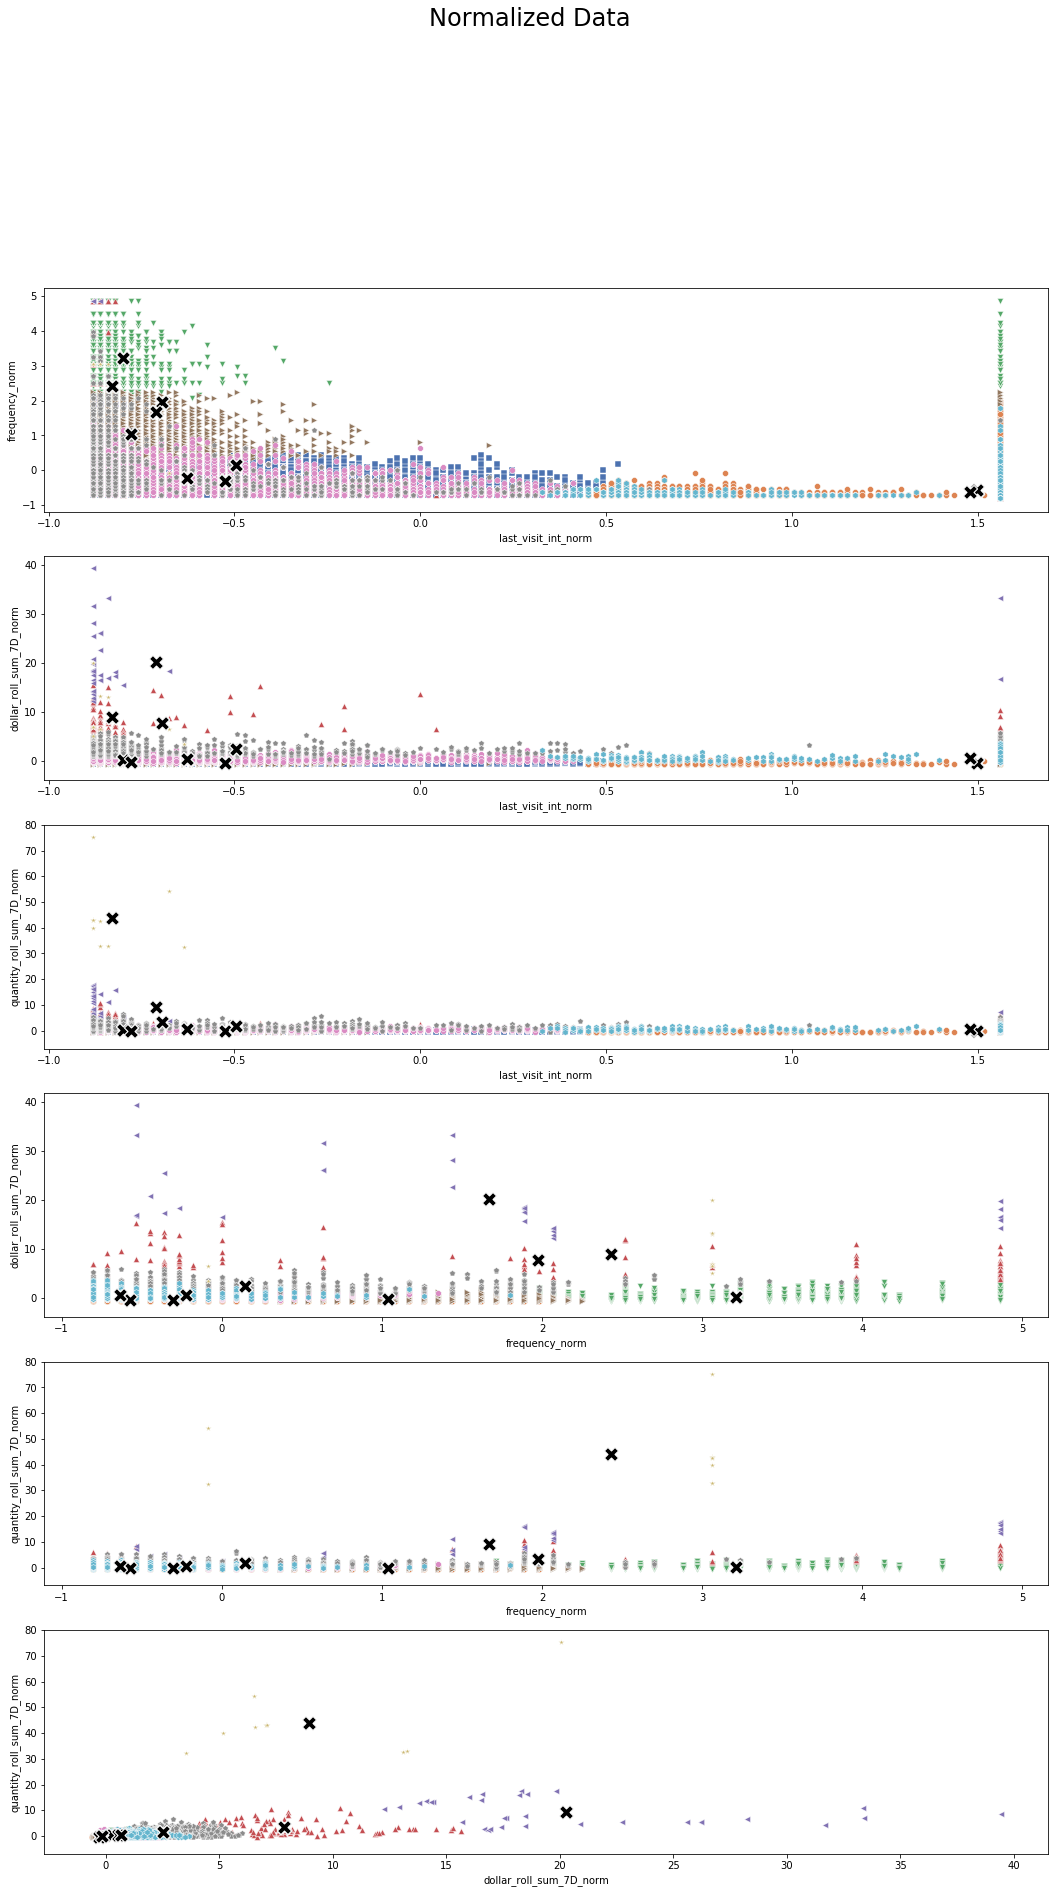

In [29]:
Plot2DKMeans(churn_roll, clusters_norm, pairs_norm, "Normalized Data")

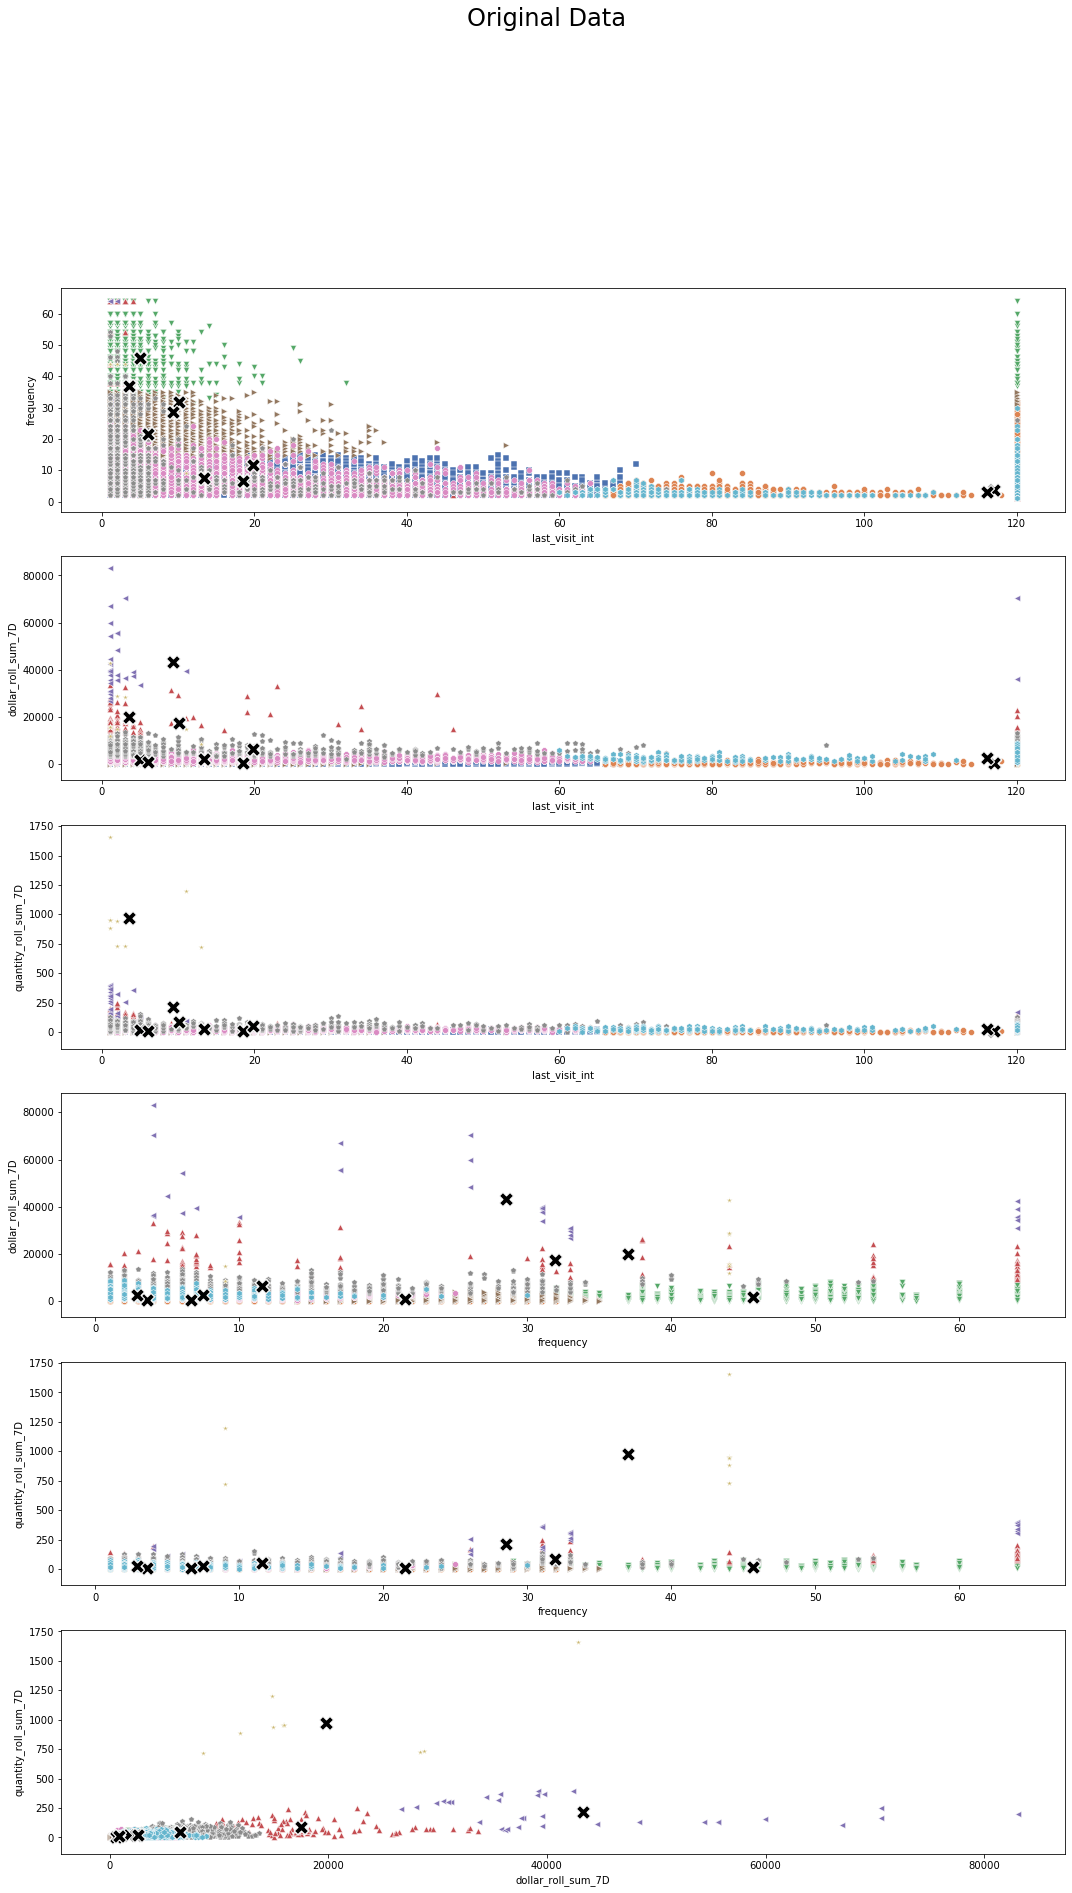

In [30]:
Plot2DKMeans(churn_roll, clusters_orig, pairs_orig, "Original Data")

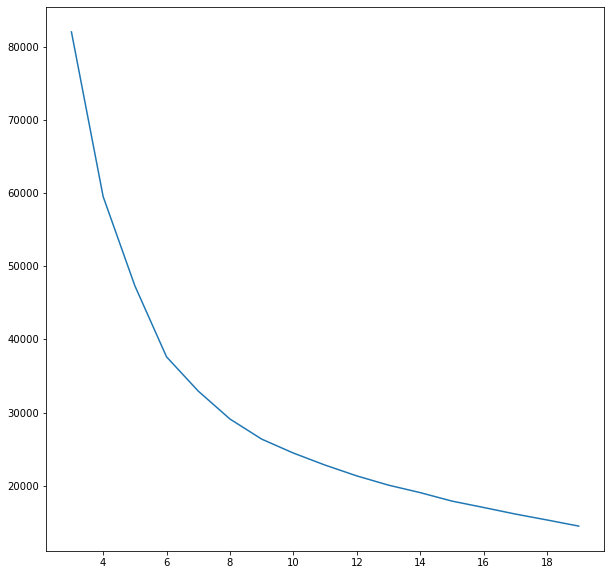

In [31]:
sample_range = (3, 20)
scree_array = np.array(calculate_scree(sample_range, churn_roll[columns_norm]))
fig, ax = plt.subplots(figsize=(10,10))
ax.ticklabel_format(style='plain')
ax.plot(range(sample_range[0], sample_range[1]), [x[1] for x in scree_array])
plt.show()

In [32]:
churn_roll.groupby('cluster').describe().T

cluster                                                   0  \
dollar_roll_sum_7D        count                       14143   
                          mean                      583.614   
                          std                       427.691   
                          min                             5   
                          25%                         245.5   
                          50%                           488   
                          75%                           840   
                          max                          2598   
quantity_roll_sum_7D      count                       14143   
                          mean                      7.16998   
                          std                       4.63016   
                          min                             1   
                          25%                             3   
                          50%                             6   
                          75%                            10   
                          max                            26   
last_visit_ndays          count                       14143   
                          mean   18 days 10:15:41.299582832   
                          std    14 days 22:13:32.812953274   
                          min               1 days 00:00:00   
                          25%               7 days 00:00:00   
                          50%              14 days 00:00:00   
                          75%              26 days 00:00:00   
                          max              70 days 00:00:00   
quantity                  count                       14143   
                          mean                       6.0811   
                          std                       4.34237   
                          min                             1   
                          25%                             3   
                          50%                             5   
                          75%                             8   
                          max                            26   
dollar                    count                       14143   
                          mean                      502.707   
                          std                       410.505   
                          min                             5   
                          25%                           193   
                          50%                           387   
                          75%                           715   
                          max                          2598   
last_visit_int            count                       14143   
                          mean                      18.4276   
                          std                       14.9261   
                          min                             1   
                          25%                             7   
                          50%                            14   
                          75%                            26   
                          max                            70   
last_visit_int_norm       count                       14143   
                          mean                    -0.524437   
                          std                      0.306089   
                          min                     -0.881824   
                          25%                     -0.758782   
                          50%                     -0.615233   
                          75%                     -0.369149   
                          max                       0.53316   
dollar_roll_sum_7D_norm   count                       14143   
                          mean                    -0.313181   
                          std                         0.206   
                          min                     -0.591874   
                          25%                     -0.476036   
                          50%                     -0.359234   
                          75%  